# Ray et al 2013 Exploratory Data Analysis
**Authorship:**
Adam Klie, *08/27/2022*
***
**Description:**
Notebook to perform a brief exploratory data analysis (EDA) on the Ray et al (2013) dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import eugene as eu
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


Matplotlib is building the font cache; this may take a moment.


# Download and load in the dataset to a raw `SeqData` object

In [2]:
# Load in the downloaded dataset from the RNAcomplete supplementary website and double check that the index and names loaded in correctly
sdata = eu.datasets.ray13()
np.all(sdata.names == sdata.seqs_annot.index)

Dataset ray13 norm_data.txt.gz has already been dowloaded.


True

In [3]:
# Pull out the columns from seqs_annot to be used as targets (based on motif ID)
target_mask = sdata.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata.seqs_annot.columns[target_mask]
len(target_cols)

244

# Sequence information

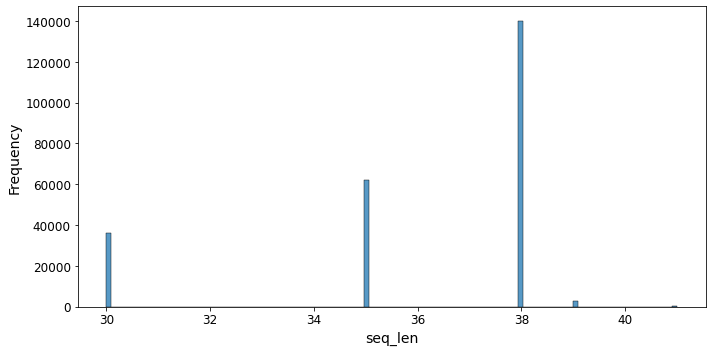

In [4]:
# Grab sequence lengths and plot distribution
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)
plt.show()

# Target information

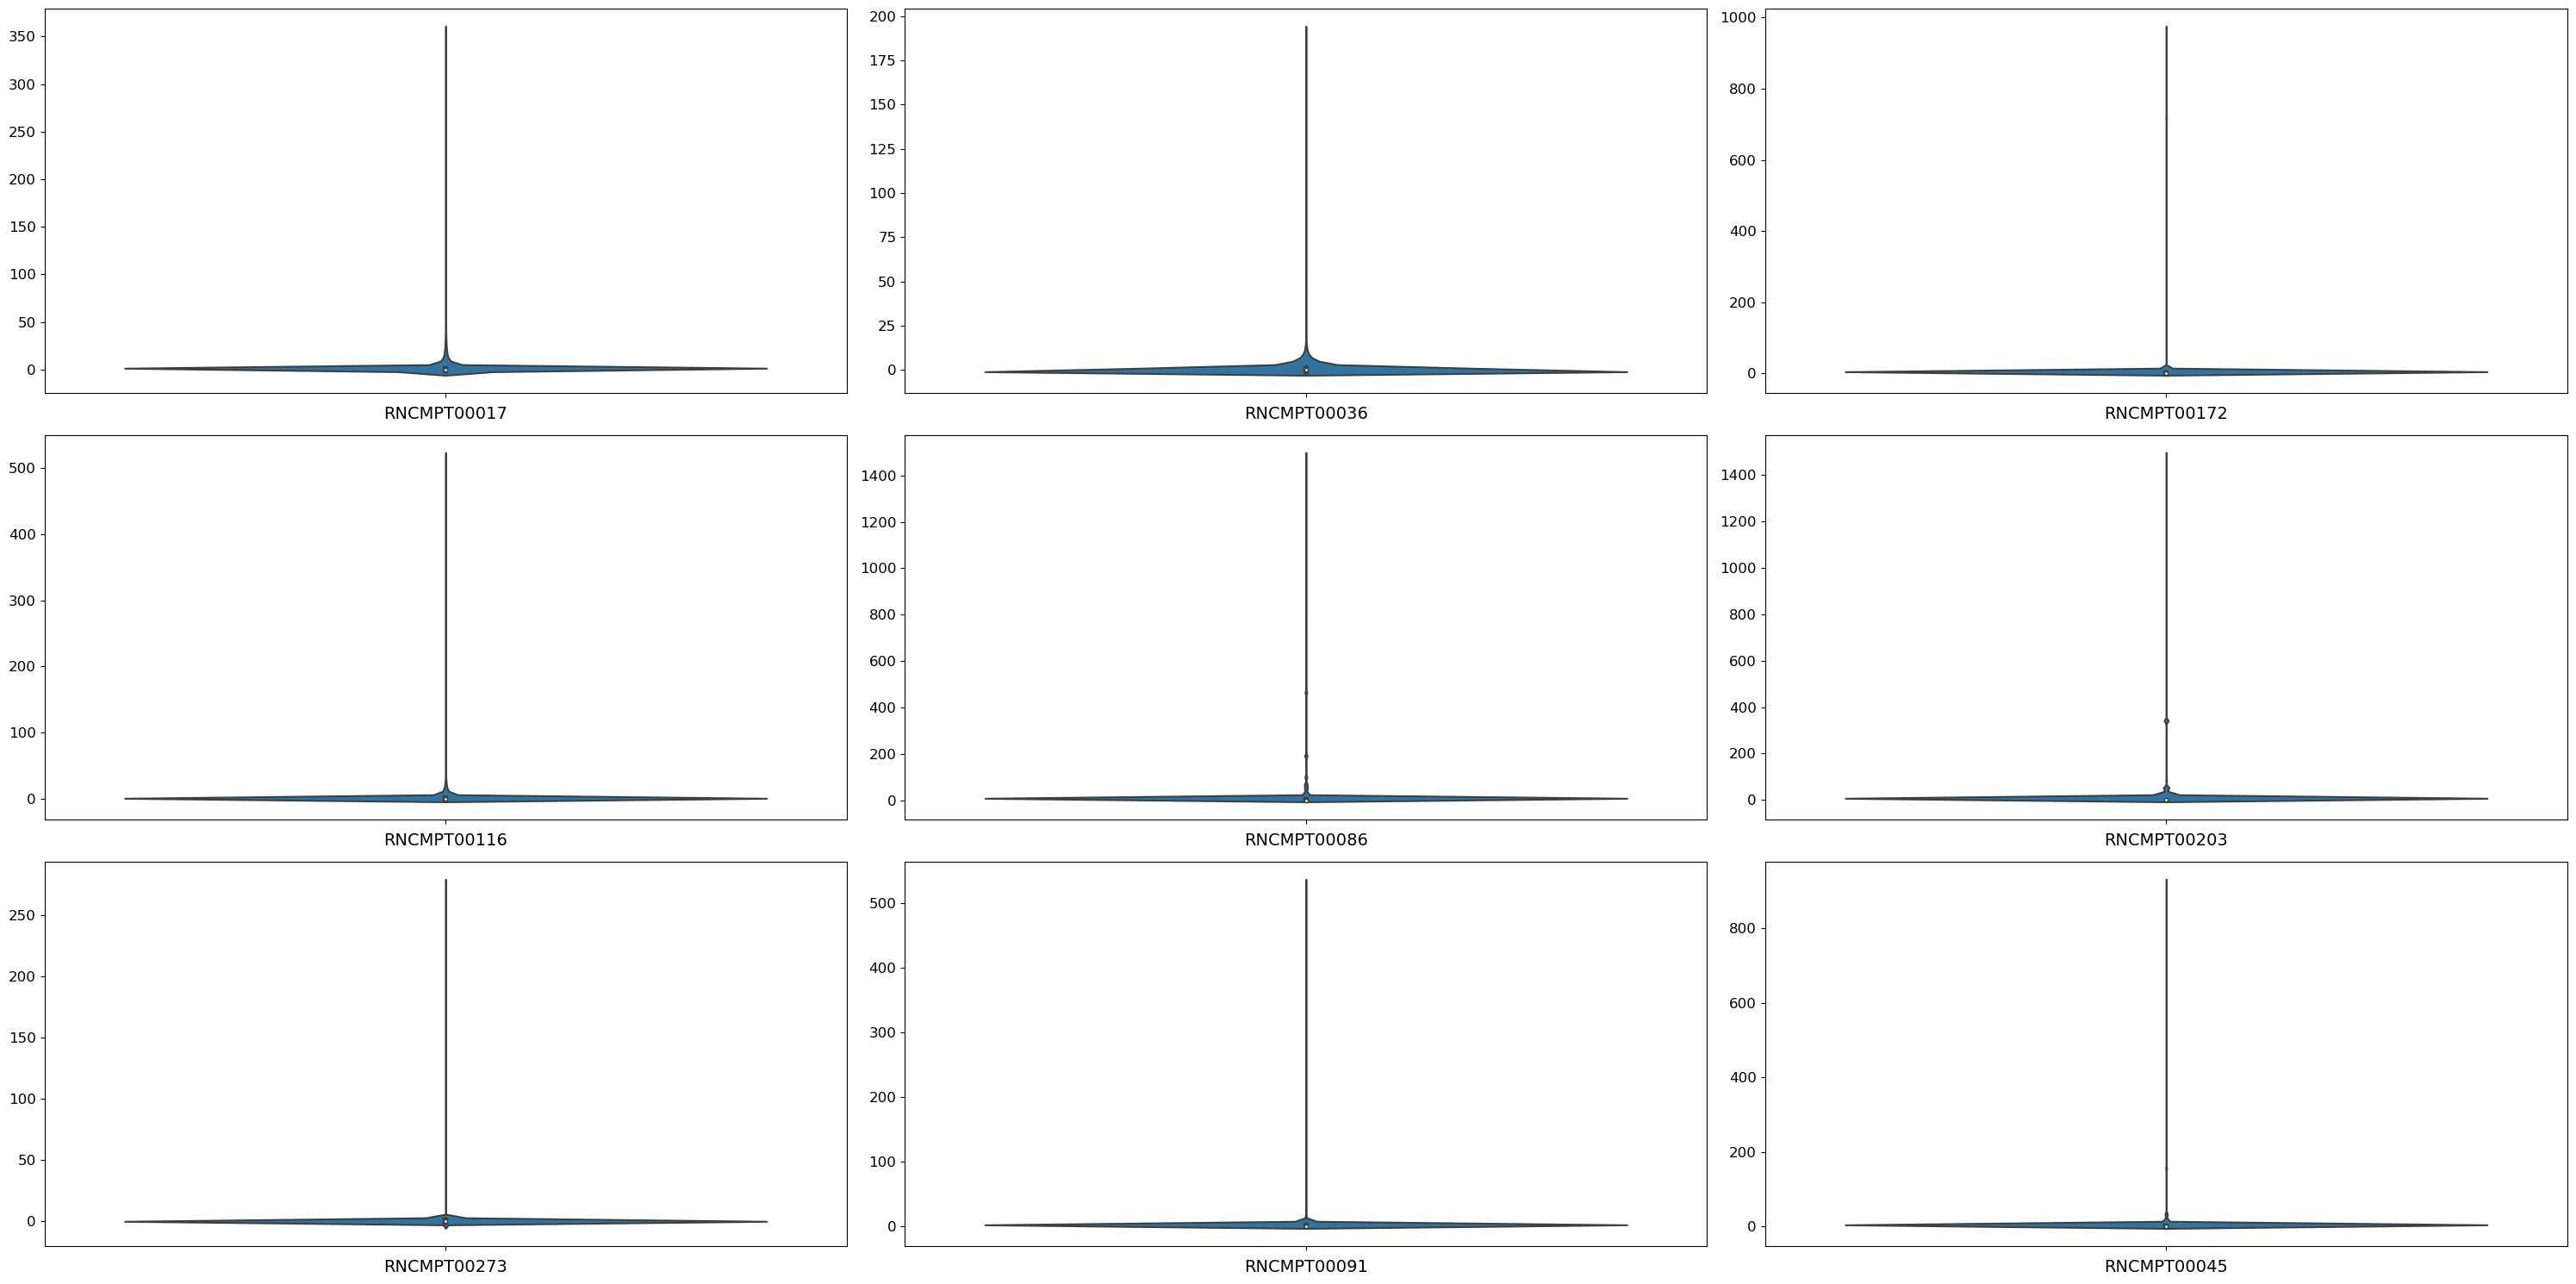

In [5]:
# Lets take a look at the distributions of a few randomly selected RBPs across all probes
eu.pl.violinplot(
    sdata, 
    keys=np.random.choice(target_cols, 9)
)
plt.show()

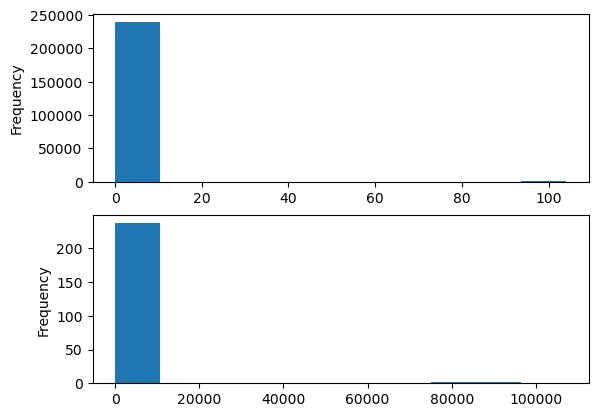

In [6]:
# Plot the number NaN values across target columns and across sequences
fig, ax = plt.subplots(nrows=2, ncols=1)
sdata.seqs_annot.isna().sum(axis=1).plot(kind="hist", ax=ax[0])
sdata.seqs_annot.isna().sum(axis=0).plot(kind="hist", ax=ax[1])
plt.show()

In [7]:
# Determine the number of targets that would be included in the dataset if we dropped those with > 1% NaN values
nan_percents = sdata.seqs_annot[target_cols].isna().sum(axis=0).sort_values(ascending=False)/sdata.seqs_annot.shape[0]
cleaned_annot = sdata.seqs_annot.drop(nan_percents[nan_percents > 0.01].index, axis=1)
cleaned_cols = target_cols.drop(nan_percents[nan_percents > 0.01].index)
cleaned_annot.head()

,Probe_Set,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,...,RNCMPT00088,RNCMPT00089,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00099,seq_len
Probe_ID,,,,,,,,,,,,,,,,,,,,,
RBD_v3_000001,SetA,1.122218,1.272641,-1.089717,-0.067146,0.831671,-0.070631,2.779642,2.509418,1.811186,...,7.101329,1.186928,0.907487,1.282393,0.861743,-0.115417,0.126413,1.010198,-0.060651,38
RBD_v3_000002,SetA,8.840295,-2.113002,2.397376,-1.809082,-0.963712,-0.202229,-0.121975,-0.038112,-0.636935,...,-0.250032,0.168827,0.029810,0.986617,3.979510,-0.388808,-0.348266,0.216500,3.820988,38
RBD_v3_000003,SetA,-0.353194,-0.183539,-0.467021,-1.865032,0.663077,0.626212,0.910989,1.431777,0.003613,...,-0.852603,-0.688271,1.821554,1.289043,-1.282063,-0.640817,0.054688,-1.351889,-0.057985,38
RBD_v3_000004,SetA,1.386679,-0.236797,-0.031135,-0.997679,-0.079547,0.473447,6.296981,7.877085,13.880688,...,6.800043,1.198766,1.121754,1.009484,0.450070,-1.106999,1.617407,0.272935,0.643033,35
RBD_v3_000005,SetA,-0.267395,1.387100,0.986554,-0.622790,-0.261790,-0.782576,-0.674672,-0.432181,0.007804,...,0.190654,2.725847,0.472460,0.476233,-0.150370,-0.545728,-0.398383,-0.677650,-0.891034,38


In [8]:
# Determine how many sequences would be included in the dataset if we dropped those with any NaN values
len(np.where(cleaned_annot[cleaned_cols].isna().sum(axis=1) == 0)[0])

221796

---

# Scratch